# Chat With Your SQL Database

_by Tuana Celik ([X](https://twitter.com/tuanacelik), [LI](https://www.linkedin.com/in/tuanacelik/))_

In this example, we are querying a SQL Database!

_Resources_:
- [Haystack Docs](https://docs.haystack.deepset.ai)
- [Haystack Tutorials](https://haystack.deepset.ai/tutorials)
- [Haystack Repo](https://github.com/deepset-ai/haystack)

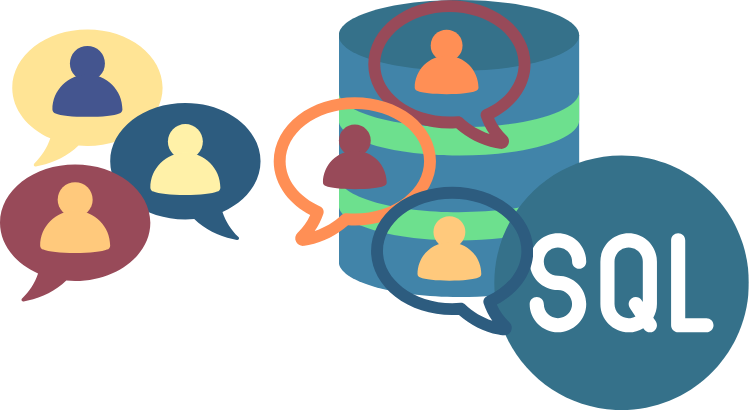

>[Chat With Your SQL Database](#scrollTo=exzYEjZRyc-K)

>>[Install dependencies](#scrollTo=ln0c4HLOyw3d)

>>[Create a SQL Query Component](#scrollTo=SM3dX8veHZn-)

>>>[Try the SQLQuery Component](#scrollTo=KOy97_-qHyS5)

>>[Query A SQL Database with Natural Language](#scrollTo=GGLuOzn9IPqd)

>>[Skip for Unrelated Questions: Add a Condition](#scrollTo=9F3MzJNmMAlY)

>>[Function Calling to Query a SQL Database](#scrollTo=13cmh8q3NZwo)

>>>[Define Tools](#scrollTo=xkdghYb6NwLq)

>>>[Try The Tool](#scrollTo=lag2_RfVN7_D)

>>[Build a Chat with SQL App](#scrollTo=2XZ6Eq9POC6C)



## Install dependencies

For this demo, we're using duckdb and jupysql. This way, we're able to simulate a SQL database within this Colab environment.

The first few code cells in this section fetchers a CSV file on 'Absenteeism' and creates a SQL table from it

In [ ]:
!pip install jupysql duckdb-engine
!pip install git+https://github.com/deepset-ai/haystack.git@main#egg=haystack-ai

  Cloning https://github.com/deepset-ai/haystack.git (to revision main) to /tmp/pip-install-zcgktvqz/haystack-ai_e84ec95174194d0890de305db760f919
  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-install-zcgktvqz/haystack-ai_e84ec95174194d0890de305db760f919
  Resolved https://github.com/deepset-ai/haystack.git to commit 5d0ccfe7d4b494ddf21dedb78bd8d98d6438c68b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
  Created wheel for haystack-ai: filename=haystack_ai-2.1.0rc0-py3-none-any.whl size=311748 sha256=9f26aae15ba61ffa0ec9d2

In [ ]:
from urllib.request import urlretrieve
from zipfile import ZipFile
import pandas as pd

url = "https://archive.ics.uci.edu/static/public/445/absenteeism+at+work.zip"

# download the file
urlretrieve(url, "Absenteeism_at_work_AAA.zip")

print("Extracting the Absenteeism at work dataset...")
# Extract the CSV file
with ZipFile("Absenteeism_at_work_AAA.zip", 'r') as zf:
    zf.extractall()

# Check the extracted CSV file name (in this case, it's "Absenteeism_at_work.csv")
csv_file_name = "Absenteeism_at_work.csv"

print("Cleaning up the Absenteeism at work dataset...")
# Data clean up
df = pd.read_csv(csv_file_name, sep=",")
df.columns = df.columns.str.replace(' ', '_')

# Save the cleaned up CSV file
df.to_csv("Absenteeism_at_work_cleaned.csv", index=False)

Extracting the Absenteeism at work dataset...
Cleaning up the Absenteeism at work dataset...


In [ ]:
%load_ext sql

Deploy FastAPI apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


In [ ]:
%sql duckdb:///absenteeism.duck.db

Connecting to 'duckdb:///absenteeism.duck.db'

In [ ]:
%%sql
create or replace table absenteeism as
from read_csv_auto('Absenteeism_at_work_cleaned.csv', header=True, sep=';')

Running query in 'duckdb:///absenteeism.duck.db'

Count


## Create a SQL Query Component

Here, we're creating a custom component called `SQLQuery`, this way, we can use it in our Haystack pipeline like any other component (like a retriever, generator etc). This component does just one thing:
- Accepts `queries` which are SQL queries
- Queries the database with those SQL queries and returns the result from the database.

In [ ]:
from typing import List
from haystack import component

@component
class SQLQuery:

    def __init__(self):
      %reload_ext sql

    @component.output_types(results=List[str], queries=List[str])
    def run(self, queries: List[str]):
        results = []
        for query in queries:
          result = %sql {{query}}
          results.append(f"{result}")
        return {"results": results, "queries": queries}

### Try the SQLQuery Component

In [ ]:
sql_query = SQLQuery()

In [ ]:
result = sql_query.run(queries=['SELECT Age, SUM(Absenteeism_time_in_hours) as Total_Absenteeism_Hours FROM absenteeism WHERE Disciplinary_failure = 0 GROUP BY Age ORDER BY Total_Absenteeism_Hours DESC LIMIT 3;'])
print(result["results"][0])

Running query in 'duckdb:///absenteeism.duck.db'

+-----+-------------------------+
| Age | Total_Absenteeism_Hours |
+-----+-------------------------+
|  28 |           651           |
|  33 |           538           |
|  38 |           482           |
+-----+-------------------------+


## Query A SQL Database with Natural Language

In this section, we're building a simple pipeline that can:
- Accept natural language questions
- Translates those questions into a SQL Query
- Queries our database using the `SQLQuery` component

**Shortcoming:** This pipeline will still run if you ask a completely unrelated question that cannot be answered with the database we have at hand. Observe how the `SQLQuery` component throws an error in these cases.


In [ ]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")


OpenAI API Key: ··········


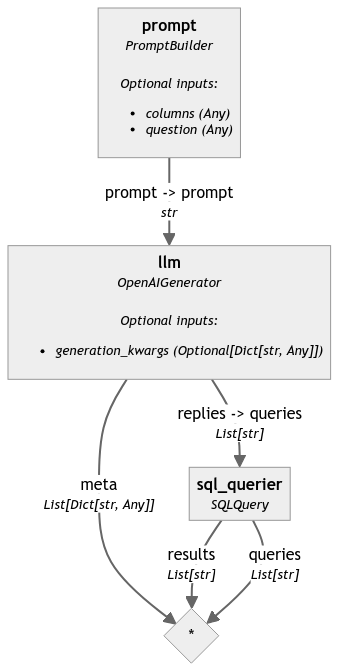

In [ ]:
import os
from getpass import getpass
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator

prompt = PromptBuilder(template="""Please generate an SQL query. The query should answer the following Question: {{question}};
            The query is to be answered for the table is called 'absenteeism' with the following
            Columns: {{columns}};
            Answer:""")
sql_query = SQLQuery()
llm = OpenAIGenerator(model="gpt-4")

sql_pipeline = Pipeline()
sql_pipeline.add_component("prompt", prompt)
sql_pipeline.add_component("llm", llm)
sql_pipeline.add_component("sql_querier", sql_query)

sql_pipeline.connect("prompt", "llm")
sql_pipeline.connect("llm.replies", "sql_querier.queries")

# If you want to draw the pipeline, uncomment below 👇
sql_pipeline.show()

In [ ]:
result = sql_pipeline.run({"prompt": {"question": "On which days of the week does the average absenteeism time exceed 4 hours?",
                            "columns": ', '.join(df.columns)}})

print(result["sql_querier"]["results"][0])

Running query in 'duckdb:///absenteeism.duck.db'

+-----------------+
| Day_of_the_week |
+-----------------+
|        2        |
|        3        |
|        4        |
|        5        |
|        6        |
+-----------------+


## Skip for Unrelated Questions: Add a Condition

Now, let's create another pipeline, to avoid having to query the database if the question is unrelated to the information present in the database. For this, we do a few things:
- We modify the prompt to answer with `no_answer` if the question cannot be answered given the database and its `columns`
- We add a conditional router that routes the query to the `SQLQuery` component only if the question was evaluated to be answerable
- We add a `fallback_prompt` and `fallback_llm` to return a statement about the fact that the question cannot be answered, along with reasons. This branch of the pipeline runs only if the question cannot be answered.

In [ ]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.routers import ConditionalRouter

prompt = PromptBuilder(template="""Please generate an SQL query. The query should answer the following Question: {{question}};
            If the question cannot be answered given the provided table and columns, return 'no_answer'
            The query is to be answered for the table is called 'absenteeism' with the following
            Columns: {{columns}};
            Answer:""")

llm = OpenAIGenerator(model="gpt-4")
sql_query = SQLQuery()

routes = [
     {
        "condition": "{{'no_answer' not in replies[0]}}",
        "output": "{{replies}}",
        "output_name": "sql",
        "output_type": List[str],
    },
    {
        "condition": "{{'no_answer' in replies[0]}}",
        "output": "{{question}}",
        "output_name": "go_to_fallback",
        "output_type": str,
    },
]

router = ConditionalRouter(routes)

fallback_prompt = PromptBuilder(template="""User entered a query that cannot be answerwed with the given table.
                                            The query was: {{question}} and the table had columns: {{columns}}.
                                            Let the user know why the question cannot be answered""")
fallback_llm = OpenAIGenerator(model="gpt-4")

conditional_sql_pipeline = Pipeline()
conditional_sql_pipeline.add_component("prompt", prompt)
conditional_sql_pipeline.add_component("llm", llm)
conditional_sql_pipeline.add_component("router", router)
conditional_sql_pipeline.add_component("fallback_prompt", fallback_prompt)
conditional_sql_pipeline.add_component("fallback_llm", fallback_llm)
conditional_sql_pipeline.add_component("sql_querier", sql_query)

conditional_sql_pipeline.connect("prompt", "llm")
conditional_sql_pipeline.connect("llm.replies", "router.replies")
conditional_sql_pipeline.connect("router.sql", "sql_querier.queries")
conditional_sql_pipeline.connect("router.go_to_fallback", "fallback_prompt.question")
conditional_sql_pipeline.connect("fallback_prompt", "fallback_llm")

#if you want to draw the pipeline, uncomment below 👇

#conditional_sql_pipeline.show()

🚅 Components
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
  - router: ConditionalRouter
  - fallback_prompt: PromptBuilder
  - fallback_llm: OpenAIGenerator
  - sql_querier: JupySQLQuery
🛤️ Connections
  - prompt.prompt -> llm.prompt (str)
  - llm.replies -> router.replies (List[str])
  - router.sql -> sql_querier.queries (List[str])
  - router.go_to_fallback -> fallback_prompt.question (str)
  - fallback_prompt.prompt -> fallback_llm.prompt (str)

In [ ]:
question = "On which days of the week does the average absenteeism time exceed 4 hours?"
columns = ', '.join(df.columns)
result = conditional_sql_pipeline.run({"prompt": {"question": question,
                                                  "columns": columns},
                                       "router": {"question": question},
                                       "fallback_prompt": {"columns": columns}})
if 'sql_querier' in result:
  print(result['sql_querier']['results'][0])
elif 'fallback_llm' in result:
  print(result['fallback_llm']['replies'][0])



Running query in 'duckdb:///absenteeism.duck.db'

+-----------------+
| Day_of_the_week |
+-----------------+
|        2        |
|        3        |
|        4        |
|        5        |
|        6        |
+-----------------+


## Function Calling to Query a SQL Database

Now let's try something a bit more fun. Instead of a component, we are going to procide sql querying as a function. Since we already built it, we can simply wrap our `SQLQuery` component into a function 👇

In [ ]:
sql_query = SQLQuery()

def sql_query_func(queries: List[str]):
    try:
      result = sql_query.run(queries)
      return {"reply": result["results"][0]}

    except Exception as e:
      reply = f"""There was an error running the SQL Query = {queries}
              The error is {e},
              You should probably try again.
              """
      return {"reply": reply}

### Define Tools

Now, let's provide this function as a tool. Below, we are using OpenAI for demonstration purposes so we abide by their function definition schema 👇

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "sql_query_func",
            "description": f"This a tool useful to query a SQL table called 'absenteeism' with the following Columns: {', '.join(df.columns)}",
            "parameters": {
                "type": "object",
                "properties": {
                    "queries": {
                        "type": "array",
                        "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
                        "items": {
                            "type": "string",
                        }
                    }
                },
                "required": ["question"],
            },
        },
    }
]

### Try The Tool

In [ ]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

messages = [
    ChatMessage.from_system(
        "You are a helpful and knowledgeable agent who has access to an SQL database which has a table called 'absenteeism'"
    ),
    ChatMessage.from_user("When is my birthday?"),
]

chat_generator = OpenAIChatGenerator(model="gpt-4", streaming_callback=print_streaming_chunk)
response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})
print(response)


I'm sorry, but as an AI, I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. I am designed to respect user privacy and confidentiality. Therefore, I don't know when your birthday is. I suggest you should keep such sensitive information secure and private.{'replies': [ChatMessage(content="I'm sorry, but as an AI, I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. I am designed to respect user privacy and confidentiality. Therefore, I don't know when your birthday is. I suggest you should keep such sensitive information secure and private.", role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'stop', 'usage': {}})]}


## Build a Chat with SQL App

First, let's install Gradio, we will use that for our mini app

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.3 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=1bf1a78a513463a27e1bca0312b2951360949a84c3a4476950734b0236bfc669
  Stored in directory: /root/.cache/pip/wheels/bd/65/9a/671fc6dcde07d4418df0c592f8df512b26d7a0029c2a23dd81
Successfully built ffmpy


In [ ]:
import gradio as gr
import json

from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator

chat_generator = OpenAIChatGenerator(model="gpt-4")
response = None
messages = [
    ChatMessage.from_system(
        "You are a helpful and knowledgeable agent who has access to an SQL database which has a table called 'absenteeism'"
    )
]


def chatbot_with_fc(message, history):
    available_functions = {"sql_query_func": sql_query_func}
    messages.append(ChatMessage.from_user(message))
    response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})

    while True:
        # if OpenAI response is a tool call
        if response and response["replies"][0].meta["finish_reason"] == "tool_calls":
            function_calls = json.loads(response["replies"][0].content)
            print(response["replies"][0])
            for function_call in function_calls:
                ## Parse function calling information
                function_name = function_call["function"]["name"]
                function_args = json.loads(function_call["function"]["arguments"])

                ## Find the correspoding function and call it with the given arguments
                function_to_call = available_functions[function_name]
                function_response = function_to_call(**function_args)

                ## Append function response to the messages list using `ChatMessage.from_function`
                messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))
                response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})

        # Regular Conversation
        else:
            messages.append(response["replies"][0])
            break
    return response["replies"][0].content


In [ ]:
demo = gr.ChatInterface(
    fn=chatbot_with_fc,
    examples=[
        "Find the top 3 ages with the highest total absenteeism hours, excluding disciplinary failures",
        "On which days of the week does the average absenteeism time exceed 4 hours?",
        "Who lives in London?",
    ],
    title="Chat with your SQL Database",
)

In [ ]:
demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://495a18e8ac78975fc1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


ChatMessage(content='[{"id": "call_DrsKGgF0HwlLvMgzgKqlskqN", "function": {"arguments": "{\\n  \\"queries\\": [\\n    \\"SELECT Day_of_the_week, AVG(Absenteeism_time_in_hours) as Average_absenteeism_time FROM absenteeism GROUP BY Day_of_the_week HAVING AVG(Absenteeism_time_in_hours) > 4\\"\\n  ]\\n}", "name": "sql_query_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 66, 'prompt_tokens': 208, 'total_tokens': 274}})


Running query in 'duckdb:///absenteeism.duck.db'

ChatMessage(content='[{"id": "call_ub83WWuyfcrC6GzPjgq9nQO8", "function": {"arguments": "{\\n\\"queries\\": [\\"SELECT Day_of_the_week, AVG(Absenteeism_time_in_hours) as Average_absenteeism FROM absenteeism GROUP BY Day_of_the_week HAVING AVG(Absenteeism_time_in_hours) > 4\\"]\\n}", "name": "sql_query_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 60, 'prompt_tokens': 483, 'total_tokens': 543}})


Running query in 'duckdb:///absenteeism.duck.db'

ChatMessage(content='[{"id": "call_bBe27sqheoGFl6LM6spbmZ0O", "function": {"arguments": "{\\n  \\"queries\\": [\\"SELECT Day_of_the_week, AVG(Absenteeism_time_in_hours) as Average_absenteeism_time FROM absenteeism GROUP BY Day_of_the_week HAVING AVG(Absenteeism_time_in_hours) > 5\\"]\\n}", "name": "sql_query_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 62, 'prompt_tokens': 746, 'total_tokens': 808}})


Running query in 'duckdb:///absenteeism.duck.db'

ChatMessage(content='[{"id": "call_CTSHPcIGeIi0ShrM3IrzIaXR", "function": {"arguments": "{\\n\\"queries\\": [\\"SELECT Day_of_the_week, AVG(Absenteeism_time_in_hours) as Average_absenteeism_time FROM absenteeism GROUP BY Day_of_the_week HAVING Average_absenteeism_time > 5\\"]\\n}", "name": "sql_query_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-0613', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 57, 'prompt_tokens': 977, 'total_tokens': 1034}})


Running query in 'duckdb:///absenteeism.duck.db'